In [1]:
import numpy as np

import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult

# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [2]:
time = '10'
date = '2023-04-14'
experiment = 'fba-redux-standard'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [3]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [4]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [5]:
stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25."]
# generate carbon mistake in parca, efflux/influx proton gen, iron cheating, mass gen
for rxn in bad_rxns:
    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices.

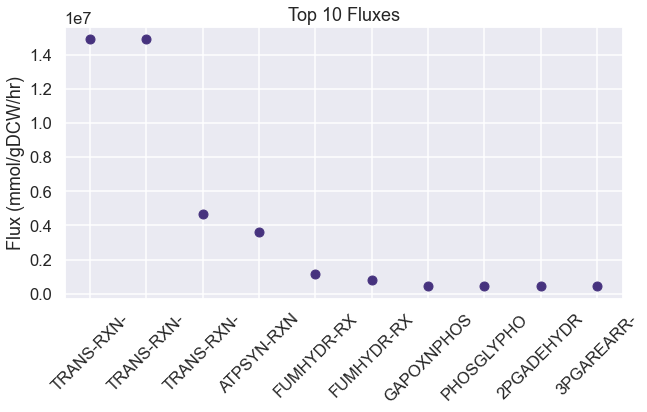

In [6]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(10, 5))
plt.plot(sim_fluxes.head(10), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(10)], [i[:10] for i in sim_fluxes.index[:10]], rotation=45)
plt.ylabel('Flux (mmol/gDCW/hr)')
plt.title('Top 10 Fluxes')
plt.show()

# Test changing nutrient composition

In [7]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'FRU[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [8]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["target_maintenance_flux"]).at[4, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]          73
2-KETOGLUTARATE[c]               187
2-PG[c]                           49
2K-4CH3-PENTANOATE[c]             72
4-AMINO-BUTYRATE[c]              161
                              ...   
WATER[c]                    22086088
XYLULOSE-5-PHOSPHATE[c]           89
ZN+2[c]                           89
ZN+2[p]                           53
glycogen-monomer[c]            35110
Name: 4, Length: 172, dtype: int64

In [9]:
model = NetworkFlowModel(reactions=stoichiometry, homeostatic_metabolites=list(dict(homeostatic).keys()))

In [10]:
model.set_up_exchanges(exchanges=list(dict(exchanges).keys()), uptakes=uptake)

In [11]:
solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   binary_kinetic_targets={},
                                   objective_weights={'secretion': 0.001, 'efficiency': 0.00001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

In [12]:
pd.Series(solution.exchanges).sort_values(ascending=False).head(10)

WATER[p]              1.736816e+07
FRU[p]                1.410108e+06
AMMONIUM[c]           1.375859e+06
OXYGEN-MOLECULE[p]    1.289748e+06
Pi[p]                 1.776750e+05
K+[p]                 5.145700e+04
SULFATE[p]            3.335100e+04
MG+2[p]               2.287000e+03
FE+2[p]               1.930000e+03
CA+2[p]               1.425000e+03
dtype: float64

In [13]:
pd.Series(solution.velocities).sort_values(ascending=False).head(10)

TRANS-RXN-145                                                                  1.736816e+07
ATPSYN-RXN (reverse)                                                           4.181745e+06
maintenance_reaction                                                           3.058992e+06
GAPOXNPHOSPHN-RXN                                                              2.307510e+06
PHOSGLYPHOS-RXN (reverse)                                                      2.307502e+06
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.          2.223745e+06
3PGAREARR-RXN (reverse)                                                        2.083406e+06
2PGADEHYDRAT-RXN                                                               2.083357e+06
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse)    1.893273e+06
TRANS-RXN0-582-FRU/PTSI-PHOSPHORYLATED//FRU1P/PTSI-MONOMER.44.                 1.410108e+06
dtype: float64

# Filter S matrix to only include nonzero fluxes.

In [14]:
# only include nonzero fluxes in solution.velocities
nonzero_velocities = {k: v for k, v in solution.velocities.items() if v != 0}

In [15]:
# Use nonzero_velocities to filter S matrix
S_matrix = model.Sd.loc[:, nonzero_velocities.keys()]

# remove rows of S_used that sum to zero.
S_matrix = S_matrix.loc[(S_matrix != 0).any(axis=1)]

In [16]:
nonzero_velocities

{'1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse)': 3851.0,
 '1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse)': 16094.999999999989,
 '1PFRUCTPHOSN-RXN': 1238117.9886565725,
 '1TRANSKETO-RXN (reverse)': 7974.0,
 '2-DEHYDROPANTOATE-REDUCT-RXN (reverse)': 1131.0000000000043,
 '2-ISOPROPYLMALATESYN-RXN': 56297.00000000001,
 '2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN': 300.0,
 '2-OCTAPRENYL-6-OHPHENOL-METHY-RXN': 300.0,
 '2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN': 300.0,
 '2-OCTAPRENYLPHENOL-HYDROX-RXN': 300.0,
 '2.3.1.157-RXN': 16505.000000000004,
 '2.5.1.19-RXN': 50577.000000000044,
 '2.5.1.64-RXN': 105.99999999999997,
 '2.7.1.148-RXN': 47391.00000000001,
 '2.7.7.60-RXN': 47391.00000000001,
 '2.8.1.6-RXN': 10.0,
 '2OXOGLUTARATEDEH-RXN': 248858.97731314733,
 '2PGADEHYDRAT-RXN': 2083356.9773131476,
 '2TRANSKETO-RXN (reverse)': 50658.00000000006,
 '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN-CPD-12996/2-KETO-ISOVALERATE/WATER//2-DEHYDROPANTOATE/CPD-1301.63.': 1131.00

In [17]:
S_matrix

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),1PFRUCTPHOSN-RXN,1TRANSKETO-RXN (reverse),2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,2-OCTAPRENYLPHENOL-HYDROX-RXN,...,ISOCHORSYN-RXN__MENF-CPLX,RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER,RXN-9535__FABB-CPLX,RXN0-313__CPLX0-201 (reverse),RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER,RXN0-5186__G7408-MONOMER,SERINE-O-ACETTRAN-RXN__CPLX0-237,SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,maintenance_reaction
NAD[c],1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADH[c],-1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PROTON[c],-1,-1,1,0,-1,1,-1,1,1,-1,...,0,0,-1,0,1,0,0,0,1,1
GLUCONATE[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADP[c],0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-3-hydroxymyristoyl-ACPs[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adenylated-ThiS-Proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ThiS-CoASH-proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thi-S[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First test. Single flux set. No eQuilibrator or regulation.

In [18]:
# sort nonzero_velocities to be in same order as S_matrix columns.
vE_dict = {k: nonzero_velocities[k] for k in S_matrix.columns}
vE = np.array([np.array(list(vE_dict.values()))])

In [19]:
Sd = S_matrix
# Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

Sd

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),1PFRUCTPHOSN-RXN,1TRANSKETO-RXN (reverse),2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,2-OCTAPRENYLPHENOL-HYDROX-RXN,...,ISOCHORSYN-RXN__MENF-CPLX,RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER,RXN-9535__FABB-CPLX,RXN0-313__CPLX0-201 (reverse),RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER,RXN0-5186__G7408-MONOMER,SERINE-O-ACETTRAN-RXN__CPLX0-237,SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,maintenance_reaction
NAD[c],1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADH[c],-1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PROTON[c],-1,-1,1,0,-1,1,-1,1,1,-1,...,0,0,-1,0,1,0,0,0,1,1
GLUCONATE[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NADP[c],0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-3-hydroxymyristoyl-ACPs[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adenylated-ThiS-Proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ThiS-CoASH-proteins[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thi-S[c],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
S_array = np.array(Sd)

# count number of times a value occurs in S_array
np.unique(S_array, return_counts=True)

(array([-8, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  8],
       dtype=int8),
 array([     2,      1,      3,      3,      5,     31,    950, 228660,
          1059,     39,      9,      3,      1,      2,      2]))

In [21]:
# K_eq = np.log(keq)
# K_eq_mod = K_eq[:, np.newaxis].T
# vE = np.array([[90, 70, -30, 50], [100, 100, 30, 50], [110, 60, 75, 50]])

# n_flux_set = vE.shape[0]
# n_flux_set = 1
Sr = None

# K_eq[vE < 0] = 1/K_eq[vE < 0]

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([vE, np.sign(vE)]), columns=Sd.columns,
             index=["$v_1$", "sign 1"])

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),1PFRUCTPHOSN-RXN,1TRANSKETO-RXN (reverse),2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,2-OCTAPRENYLPHENOL-HYDROX-RXN,...,ISOCHORSYN-RXN__MENF-CPLX,RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER,RXN-9535__FABB-CPLX,RXN0-313__CPLX0-201 (reverse),RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER,RXN0-5186__G7408-MONOMER,SERINE-O-ACETTRAN-RXN__CPLX0-237,SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,maintenance_reaction
$v_1$,3851.0,16095.0,1.238118e+06,7974.0,1131.0,56297.0,300.0,300.0,300.0,300.0,...,25.0,3.0,119.0,31.0,4.0,2979.0,17162.0,16186.0,143.0,3.058992e+06
sign 1,1.0,1.0,1.000000e+00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00


# Use the class based method to solve the problem

In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
from convex_kinetics_new import ConvexKineticsNew

In [24]:
E = ConvexKineticsNew()
y_f, y_r, y_s, y_p, y_i, y_a, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE)

Number of metabolites: 491, number of reactions: 470, number of flux sets: 1
Number of Km_s: 995, number of Km_p: 1115, number of Km_i: None, number of Km_a: None
Number of concentrations: (491, 1), number of y_f: (1, 995), number of y_r: (1, 1115)


In [25]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

Shape of C_alpha: (1828, 995), shape of C_beta: (2478, 1115)
Shape of d_alpha: (1828,), shape of d_beta: (2478,)


In [26]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, d_beta, S_s_nz, S_p_nz, S, y_f, y_r, y_s, y_p, cfwd, crev)

In [27]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, LSE_expr, denom_expr)

In [28]:
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, lower_bound=-12, upper_bound=18)

In [29]:
problem = E.set_up_problem(loss, constr)


/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [30]:
solution = E.solve(problem)


In [31]:
solution.value

51.982381865698734

In [32]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[3.85100015e+03 1.60950006e+04 1.23811803e+06 7.97400020e+03
 1.13100004e+03 5.62970026e+04 3.00000022e+02 3.00000010e+02
 3.00000010e+02 3.00000022e+02 1.65050006e+04 5.05770013e+04
 1.06000004e+02 4.73910016e+04 4.73910018e+04 1.00000012e+01
 2.48858989e+05 2.08335702e+06 5.06580013e+04 1.13100004e+03
 5.05840010e+04 5.05840010e+04 3.00000008e+02 4.00000010e+00
 1.96800005e+03 3.07090008e+04 2.08340601e+06 3.00000008e+02
 7.77200011e+03 1.65050002e+04 7.51950019e+04 8.31240021e+04
 5.68000015e+02 1.11928004e+05 9.02660023e+04 3.92070015e+04
 3.92070015e+04 1.00000002e+01 4.64800012e+04 4.64580012e+04
 4.64800012e+04 7.00000014e+00 3.33480011e+04 9.90000027e+01
 1.07100003e+03 2.82300007e+03 2.77348006e+05 3.62220022e+04
 3.33480011e+04 5.30000018e+01 4.39090008e+04 5.71510015e+04
 4.39580021e+04 8.14150021e+04 4.79000007e+03 3.62220007e+04
 6.46800032e+03 3.62390007e+04 3.63320022e+04 2.95130018e+04
 1.28030981e+05 4.27027986e+05 6.73230031e+04 4.39840011e+04
 4.24060014e+04 1.131000

In [33]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
# df_reconstr_comp



[Text(0, 0, 'TRANS-RXN-145'),
 Text(0, 1, 'ATPSYN-RXN (reverse)'),
 Text(0, 2, 'maintenance_reaction'),
 Text(0, 3, 'GAPOXNPHOSPHN-RXN'),
 Text(0, 4, 'PHOSGLYPHOS-RXN (rev'),
 Text(0, 5, 'NADH-DEHYDROG-A-RXN-'),
 Text(0, 6, '3PGAREARR-RXN (rever'),
 Text(0, 7, '2PGADEHYDRAT-RXN'),
 Text(0, 8, 'TRANS-RXN0-545[CCO-P'),
 Text(0, 9, 'TRANS-RXN0-582-FRU/P'),
 Text(0, 10, 'RXN0-6717'),
 Text(0, 11, 'TRANS-RXN0-474'),
 Text(0, 12, 'RXN-21817-CPD-9956/P'),
 Text(0, 13, '1PFRUCTPHOSN-RXN'),
 Text(0, 14, 'TRIOSEPISOMERIZATION'),
 Text(0, 15, 'F16ALDOLASE-RXN__FRU'),
 Text(0, 16, 'TRANS-RXN0-277 (reve'),
 Text(0, 17, 'PYRUVDEH-RXN'),
 Text(0, 18, 'RXN0-5224 (reverse)'),
 Text(0, 19, 'GLUTDEHYD-RXN (rever'),
 Text(0, 20, 'INORGPYROPHOSPHAT-RX'),
 Text(0, 21, 'BIOTIN-CARBOXYL-RXN'),
 Text(0, 22, 'RXN0-5055'),
 Text(0, 23, 'MALONYL-COA-ACP-TRAN'),
 Text(0, 24, 'CITSYN-RXN'),
 Text(0, 25, 'RXN-14047'),
 Text(0, 26, 'ASPARTASE-RXN (rever'),
 Text(0, 27, 'ISOCITDEH-RXN'),
 Text(0, 28, 'PEPCARBOX-RXN (r

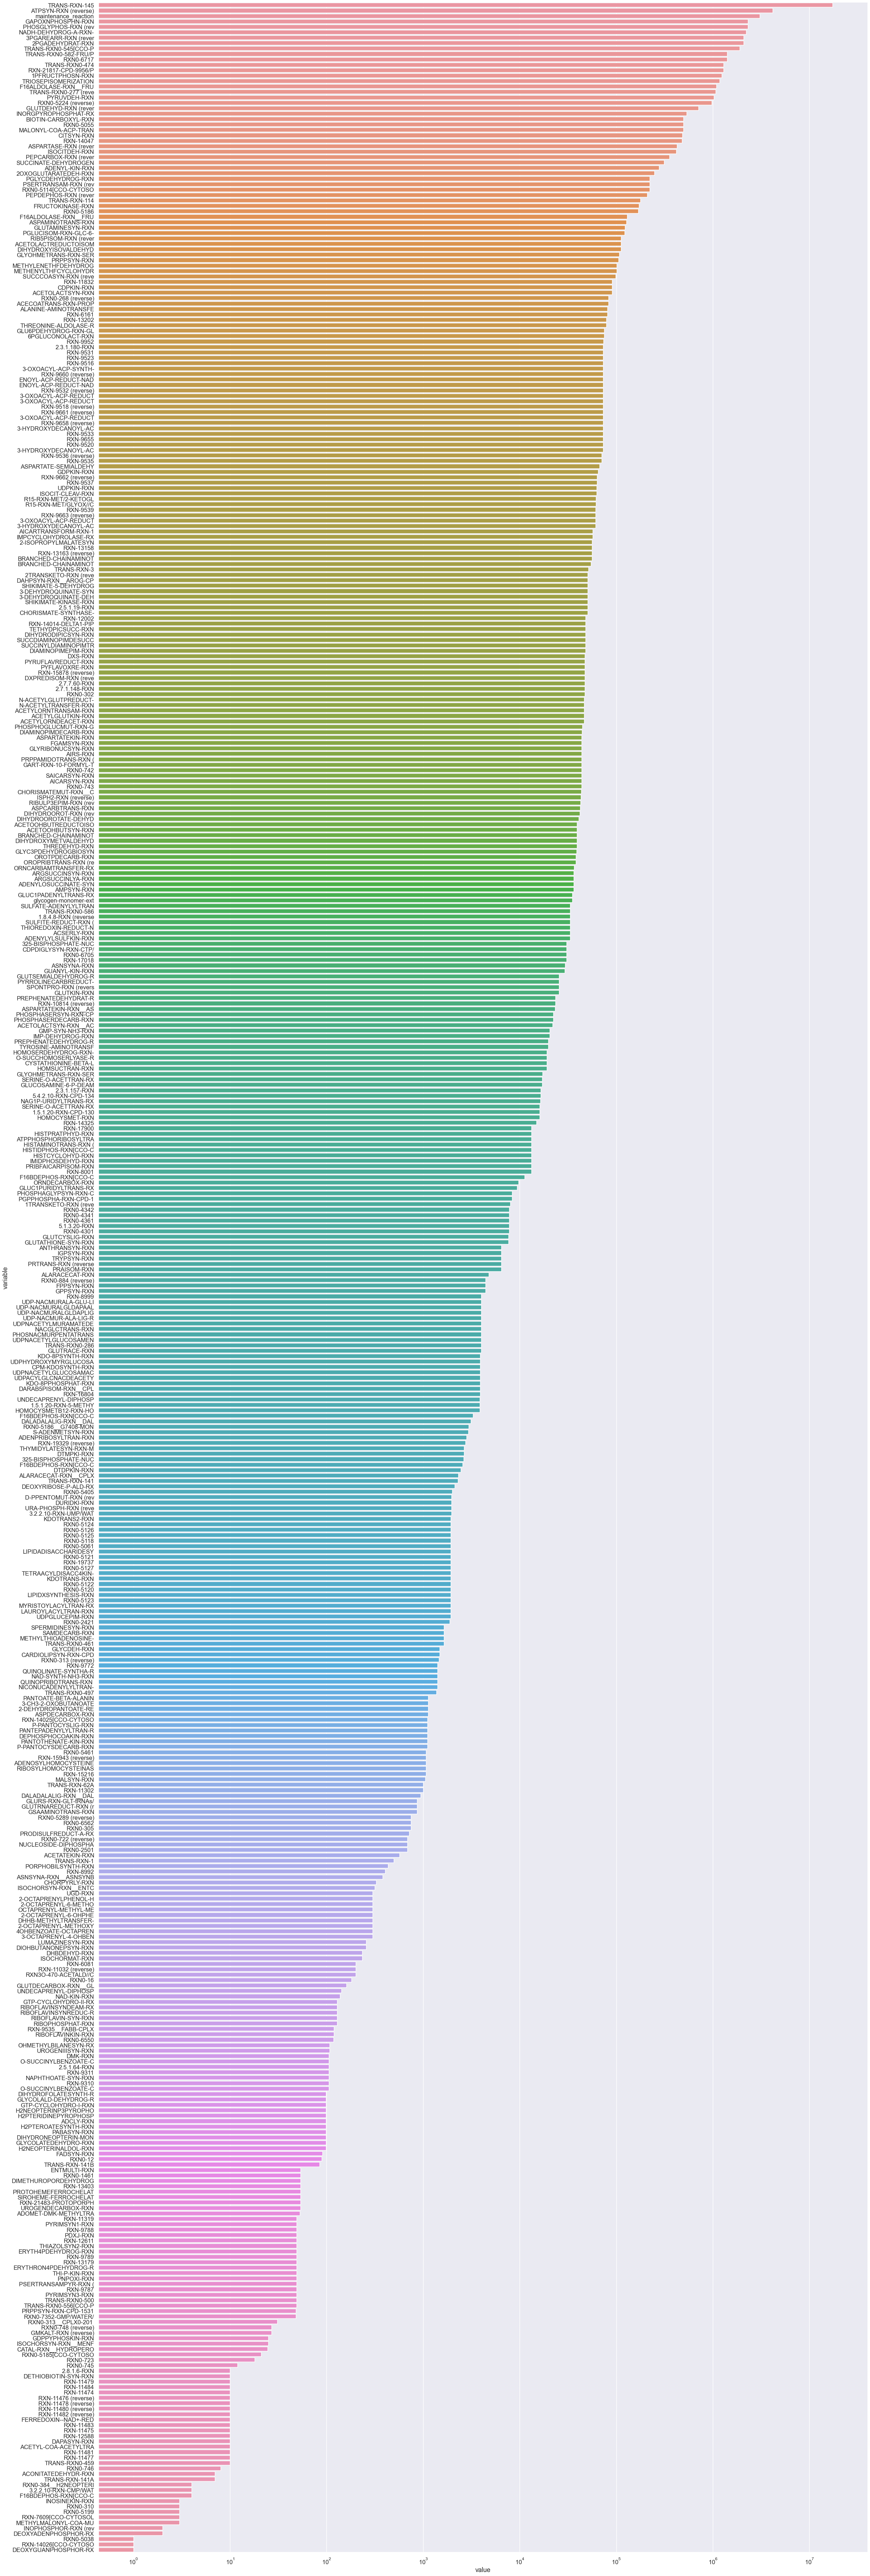

In [34]:
# sort df_reconstr_comp by value
df_reconstr_comp = df_reconstr_comp.sort_values(by="value", ascending=False).reset_index(drop=True)

sns.catplot(y="variable", x="value", data=df_reconstr_comp, kind="bar", height=100, aspect=0.5)

# change x axis to log scale
plt.xscale('log')

# limit length of y axis labels to 20 characters
plt.gca().set_yticklabels([t.get_text()[:20] for t in plt.gca().get_yticklabels()])

In [35]:
Sd.loc[:, "ADCLY-RXN"]

NAD[c]                          0
NADH[c]                         0
PROTON[c]                       1
GLUCONATE[c]                    0
NADP[c]                         0
                               ..
R-3-hydroxymyristoyl-ACPs[c]    0
Adenylated-ThiS-Proteins[c]     0
ThiS-CoASH-proteins[c]          0
Thi-S[c]                        0
FRU[p]                          0
Name: ADCLY-RXN, Length: 491, dtype: int8